In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob

In [2]:
SEED = 0

In [47]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "M2FGB_grad" : "#8da0cb",
    "M2FGB" : "#66c2a5",
    "MinimaxPareto" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "M2FGB_grad" : "M²FGB",
    "M2FGB" : "M²FGB opt.",
    "MinMaxFair" : "MinMaxFair",
    "MinimaxPareto" : "MMPF"
}

In [45]:
def get_result_metric(dataset_name, model_name, path, fair_metric = "min_bal_acc", max_models = None):
    results = []

    n_folds = len(glob(path + "validation_fold_*.csv"))
    print(n_folds)
    for i in range(n_folds):
        results_val = pd.read_csv(path + f"validation_fold_{i}.csv")

        if i == 0:
            model_list = results_val.model.unique()
            if max_models is not None and len(model_list) > max_models:
                model_list = np.random.choice(model_list, size = max_models, replace = False)


        if max_models is not None:
            results_val = results_val[results_val.model.isin(model_list)]

        if fair_metric in ["eod", "spd"]:
            results_val[fair_metric] = 1 - np.abs(results_val[fair_metric])

        results_val["score"] = results_val["alpha"] * results_val["bal_acc"] + (1 - results_val["alpha"]) * (results_val[fair_metric])

        

        results_val = results_val.groupby("alpha").apply(lambda x: x.sort_values("score", ascending=False).head(1), include_groups = False).reset_index()
        alpha_list = results_val.alpha.tolist()
        best_models = results_val.model.tolist()

        results_test = pd.read_csv(path + f"test_fold_{i}.csv")
        if fair_metric in ["eod", "spd"]:
            results_test[fair_metric] = 1 - np.abs(results_test[fair_metric])

        for alpha, m in zip(alpha_list, best_models):
            best_model = results_test[((results_test.alpha == alpha) & (results_test.model == m))]
            results.append({
                "fold" : i,
                "alpha" : alpha,
                "bal_acc" : best_model.bal_acc.values[0],
                fair_metric : best_model[fair_metric].values[0] 
            })

    results = pd.DataFrame(results).groupby("alpha").mean().reset_index()
    return results

In [58]:
model_name = "MinMaxFair"

trials = [pd.read_csv(f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/trials_fold_{i}.csv") for i in range(10)]
trials = pd.concat(trials)
trials["duration"] = pd.to_timedelta(trials["duration"])
trials.duration.mean()

Timedelta('0 days 00:00:26.325415577')

In [55]:
model_name = "M2FGB_grad"

trials = [pd.read_csv(f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/trials_fold_{i}.csv") for i in range(10)]
trials = pd.concat(trials)
trials["duration"] = pd.to_timedelta(trials["duration"])
trials.duration.mean()

Timedelta('0 days 00:00:02.162534631')

## German

10
10
10
10
10
10
10
10
10
10
10
10


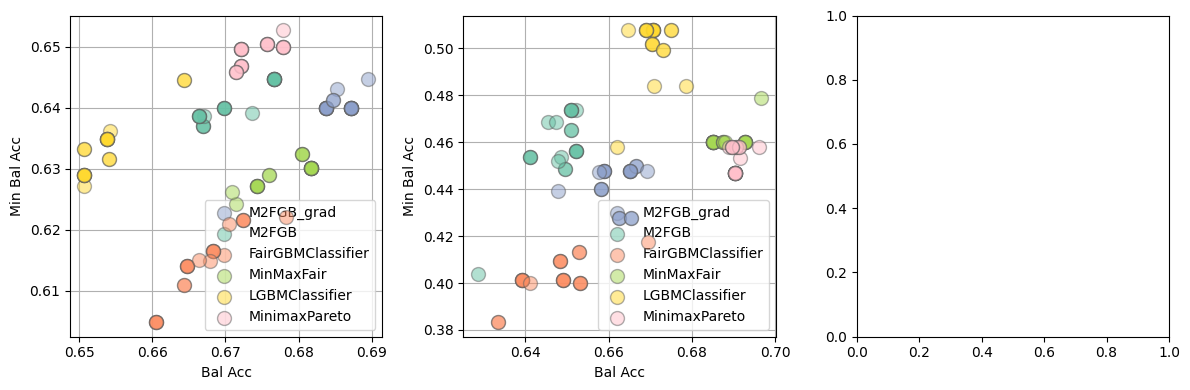

In [48]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))


dataset_name = "german"
methods = [
    "M2FGB_grad",
    "M2FGB",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier",
    "MinimaxPareto"
]
for i, n_groups in enumerate([2, 4, ]):
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results = get_result_metric(dataset_name, model_name, path, max_models = 100)

   
        axs[i].scatter(
            results.bal_acc,
            results.min_bal_acc,
            c = methods_color[model_name],
            s = 100,
            alpha = 0.5,
            label = model_name,
            lw = 1,
            zorder = 10,
            ec = "#606060",
        )

    
    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel("Min Bal Acc")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


## Compas

10
10
10
10
10
10
10
10
10
10
10
10


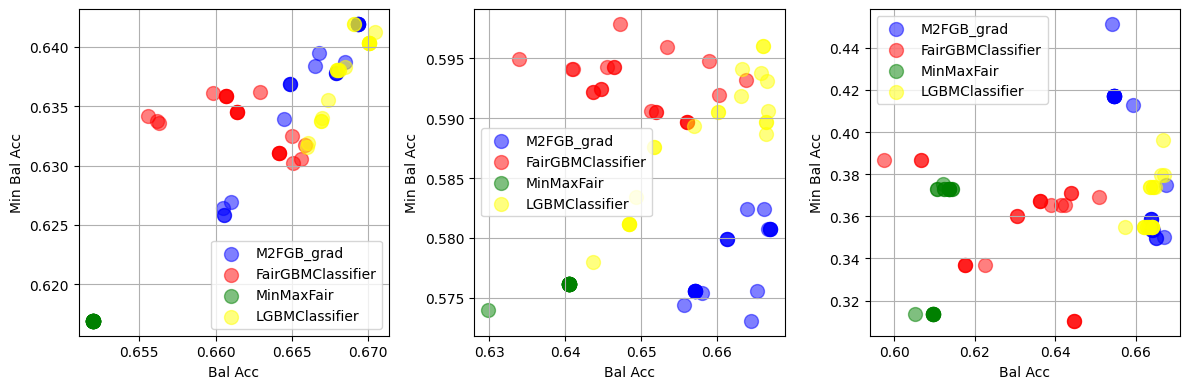

In [13]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4))


dataset_name = "compas"
methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    "MinMaxFair",
    "LGBMClassifier"
]
colors = {
    "M2FGB_grad" : "blue",
    "FairGBMClassifier" : "red",
    "MinMaxFair" : "green",
    "LGBMClassifier" : "yellow",
}
for i, n_groups in enumerate([2, 4, 8]):
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results = get_result_dataframe(dataset_name, model_name, path)

   
        axs[i].scatter(
            results.bal_acc,
            results.min_bal_acc,
            c = colors[model_name],
            s = 100,
            alpha = 0.5,
            label = model_name
        )

    
    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel("Min Bal Acc")
    axs[i].grid(True)

plt.tight_layout()
plt.show()


10
10
10
10
10
10
10
10
10


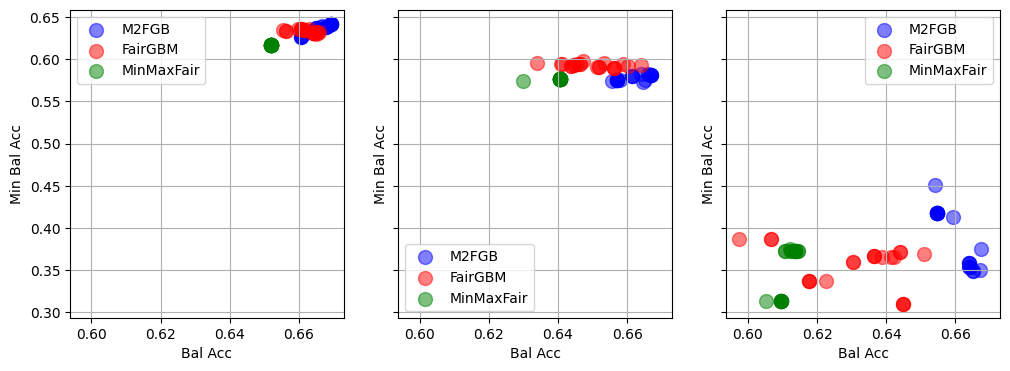

In [4]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


dataset_name = "compas"
for i, n_groups in enumerate([2, 4, 8]):
    model_name = "M2FGB_grad"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

    model_name = "FairGBMClassifier"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

    model_name = "MinMaxFair"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_mmfair = get_result_dataframe(dataset_name, model_name, path)


    axs[i].scatter(
        results_m2fgb.bal_acc,
        results_m2fgb.min_bal_acc,
        c = "blue",
        s = 100,
        alpha = 0.5,
        label = "M2FGB"
    )

    axs[i].scatter(
        results_fairgbm.bal_acc,
        results_fairgbm.min_bal_acc,
        c = "red",
        s = 100,
        alpha = 0.5,
        label = "FairGBM",
    )


    axs[i].scatter(
        results_mmfair.bal_acc,
        results_mmfair.min_bal_acc,
        c = "green",
        s = 100,
        alpha = 0.5,
        label = "MinMaxFair",
    )

    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel("Min Bal Acc")
    axs[i].grid(True)
plt.show()


10
10
10
10
10
10
10
10
10


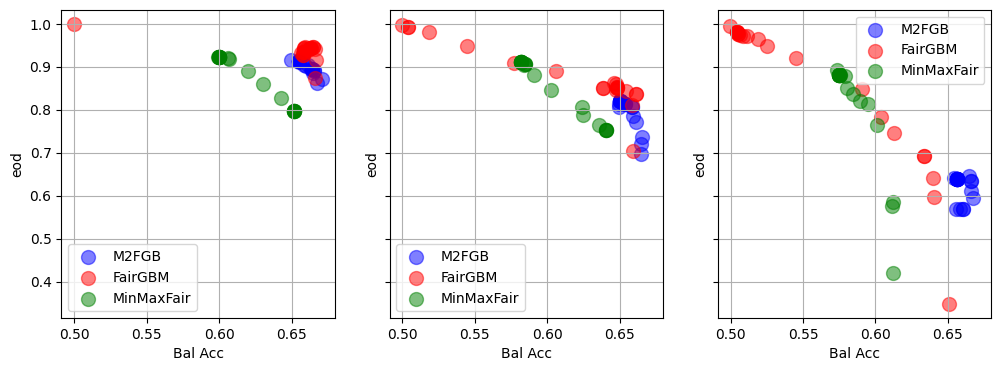

In [26]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


fair_metric = "eod"
dataset_name = "compas"
for i, n_groups in enumerate([2, 4, 8]):
    model_name = "M2FGB_grad"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_m2fgb = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "FairGBMClassifier"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_fairgbm = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "MinMaxFair"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_mmfair = get_result_metric(dataset_name, model_name, path, fair_metric)


    axs[i].scatter(
        results_m2fgb.bal_acc,
        results_m2fgb[fair_metric],
        c = "blue",
        s = 100,
        alpha = 0.5,
        label = "M2FGB"
    )

    axs[i].scatter(
        results_fairgbm.bal_acc,
        results_fairgbm[fair_metric],
        c = "red",
        s = 100,
        alpha = 0.5,
        label = "FairGBM",
    )


    axs[i].scatter(
        results_mmfair.bal_acc,
        results_mmfair[fair_metric],
        c = "green",
        s = 100,
        alpha = 0.5,
        label = "MinMaxFair",
    )

    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel(fair_metric)
    axs[i].grid(True)
plt.show()


## Adult

10
10
10
10
10
10


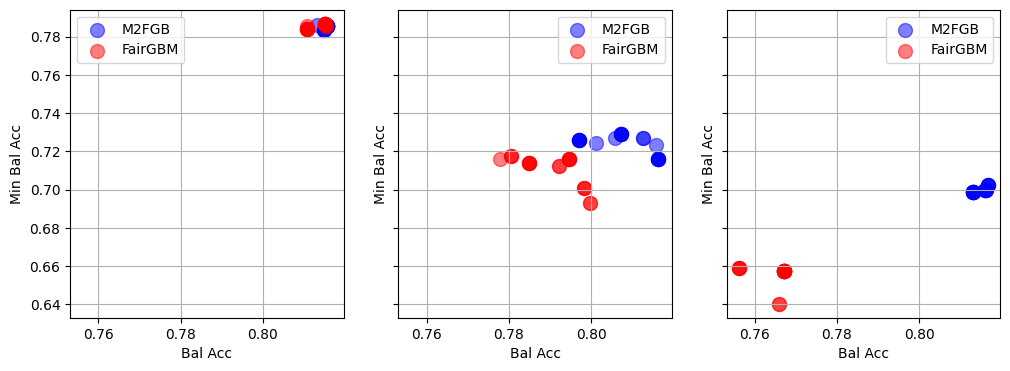

In [29]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


dataset_name = "adult"
for i, n_groups in enumerate([2, 4, 8]):
    
    model_name = "M2FGB_grad"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_m2fgb = get_result_dataframe(dataset_name, model_name, path)

    model_name = "FairGBMClassifier"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_fairgbm = get_result_dataframe(dataset_name, model_name, path)

    model_name = "MinMaxFair"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    #results_mmfair = get_result_dataframe(dataset_name, model_name, path)


    axs[i].scatter(
        results_m2fgb.bal_acc,
        results_m2fgb.min_bal_acc,
        c = "blue",
        s = 100,
        alpha = 0.5,
        label = "M2FGB"
    )

    axs[i].scatter(
        results_fairgbm.bal_acc,
        results_fairgbm.min_bal_acc,
        c = "red",
        s = 100,
        alpha = 0.5,
        label = "FairGBM",
    )


    #axs[i].scatter(
    #    results_mmfair.bal_acc,
    #    results_mmfair.min_bal_acc,
    #    c = "green",
    #    s = 100,
    #    alpha = 0.5,
    #    label = "MinMaxFair",
    #)

    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel("Min Bal Acc")
    axs[i].grid(True)
plt.show()


10
10
10
10
10
10


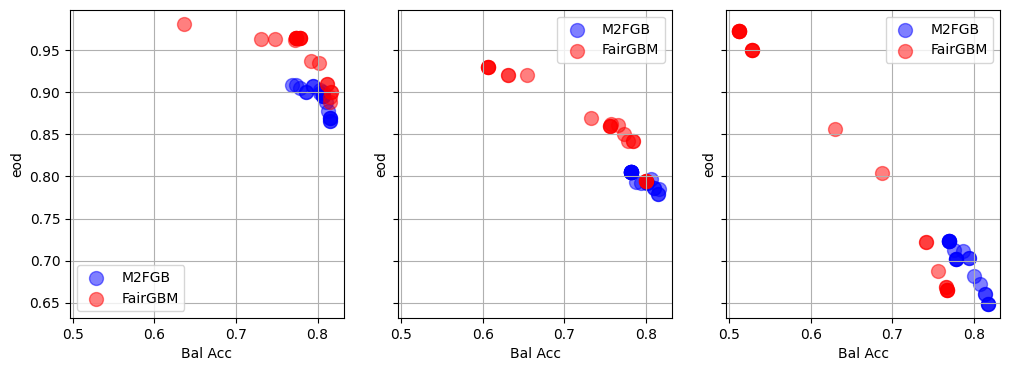

In [30]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


fair_metric = "eod"
dataset_name = "adult"
for i, n_groups in enumerate([2, 4, 8]):
    model_name = "M2FGB_grad"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_m2fgb = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "FairGBMClassifier"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_fairgbm = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "MinMaxFair"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    #results_mmfair = get_result_metric(dataset_name, model_name, path, fair_metric)


    axs[i].scatter(
        results_m2fgb.bal_acc,
        results_m2fgb[fair_metric],
        c = "blue",
        s = 100,
        alpha = 0.5,
        label = "M2FGB"
    )

    axs[i].scatter(
        results_fairgbm.bal_acc,
        results_fairgbm[fair_metric],
        c = "red",
        s = 100,
        alpha = 0.5,
        label = "FairGBM",
    )


    # axs[i].scatter(
    #     results_mmfair.bal_acc,
    #     results_mmfair[fair_metric],
    #     c = "green",
    #     s = 100,
    #     alpha = 0.5,
    #     label = "MinMaxFair",
    # )

    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel(fair_metric)
    axs[i].grid(True)
plt.show()


## ACSIncome

10
10
10
10
10
10
10
10
10


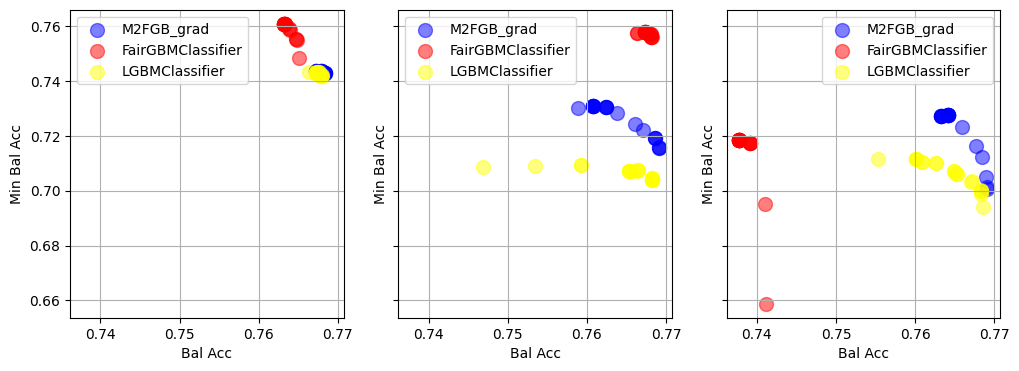

In [7]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


dataset_name = "acsincome"
methods = [
    "M2FGB_grad",
    "FairGBMClassifier",
    #"MinMaxFair",
    "LGBMClassifier"
]
colors = {
    "M2FGB_grad" : "blue",
    "FairGBMClassifier" : "red",
    "MinMaxFair" : "green",
    "LGBMClassifier" : "yellow",
}
for i, n_groups in enumerate([2, 4, 8]):
    for model_name in methods:
        path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
        results = get_result_dataframe(dataset_name, model_name, path)

   
        axs[i].scatter(
            results.bal_acc,
            results.min_bal_acc,
            c = colors[model_name],
            s = 100,
            alpha = 0.5,
            label = model_name
        )

    
    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel("Min Bal Acc")
    axs[i].grid(True)
plt.show()


10
10
10
10


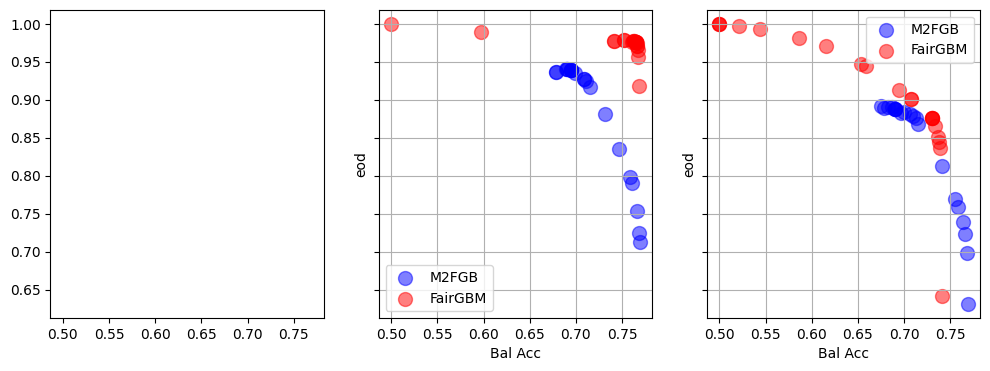

In [33]:
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (12, 4), sharex = True, sharey = True)


fair_metric = "eod"
dataset_name = "acsincome"
for i, n_groups in enumerate([2, 4, 8]):
    if i == 0:
        continue
    model_name = "M2FGB_grad"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_m2fgb = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "FairGBMClassifier"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    results_fairgbm = get_result_metric(dataset_name, model_name, path, fair_metric)

    model_name = "MinMaxFair"
    path = f"../results/experiment_{n_groups}_groups/{dataset_name}/{model_name}/"
    #results_mmfair = get_result_metric(dataset_name, model_name, path)


    axs[i].scatter(
        results_m2fgb.bal_acc,
        results_m2fgb[fair_metric],
        c = "blue",
        s = 100,
        alpha = 0.5,
        label = "M2FGB"
    )

    axs[i].scatter(
        results_fairgbm.bal_acc,
        results_fairgbm[fair_metric],
        c = "red",
        s = 100,
        alpha = 0.5,
        label = "FairGBM",
    )


    #axs[i].scatter(
    #    results_mmfair.bal_acc,
    #    results_mmfair.min_bal_acc,
    #    c = "green",
    #    s = 100,
    #    alpha = 0.5,
    #    label = "MinMaxFair",
    #)

    axs[i].legend()
    axs[i].set_xlabel("Bal Acc")
    axs[i].set_ylabel(fair_metric)
    axs[i].grid(True)
plt.show()
